Simplified Neural ODE
Training model...


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 343.83it/s]



Epoch 10/100
Train Loss: 0.407421, Val Loss: 0.293427


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 339.45it/s]



Epoch 20/100
Train Loss: 0.395808, Val Loss: 0.287820


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 334.80it/s]



Epoch 30/100
Train Loss: 0.393020, Val Loss: 0.283958


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 342.24it/s]



Epoch 40/100
Train Loss: 0.391856, Val Loss: 0.284103


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 343.57it/s]



Epoch 50/100
Train Loss: 0.390387, Val Loss: 0.282672


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 343.34it/s]



Epoch 60/100
Train Loss: 0.389637, Val Loss: 0.283541


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 341.30it/s]



Epoch 70/100
Train Loss: 0.389891, Val Loss: 0.282435


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 338.92it/s]



Epoch 80/100
Train Loss: 0.389297, Val Loss: 0.283177


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 341.66it/s]



Epoch 90/100
Train Loss: 0.389184, Val Loss: 0.283017


Training: 100%|████████████████████████████████| 72/72 [00:00<00:00, 340.96it/s]



Epoch 100/100
Train Loss: 0.389009, Val Loss: 0.282757


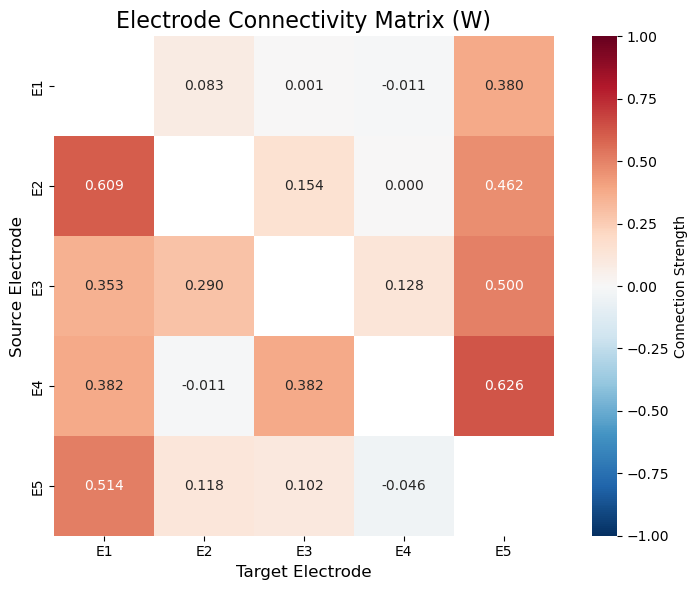


Final Network Summary:
Mean connection strength: 0.2576
Max connection strength: 0.6255

Key electrode connections (|w| > 0.05):
  E5 → E4: +0.626
  E1 → E2: +0.609
  E1 → E5: +0.514
  E5 → E3: +0.500
  E5 → E2: +0.462
  E3 → E4: +0.382
  E1 → E4: +0.382
  E5 → E1: +0.380
  E1 → E3: +0.353
  E2 → E3: +0.290


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ElectrodeDynamicsDataLoader:
    def __init__(self, data_path='./', ephys_folder='data_ephys', behav_folder='data_behav'):
        self.data_path = Path(data_path)
        self.ephys_path = self.data_path / ephys_folder
        self.behav_path = self.data_path / behav_folder
        self.scaler = StandardScaler()
        
    def load_subject_data(self, subject_id, verbose=True):
        ephys_file = self.ephys_path / f's{subject_id:02d}_ofc_hg_events.mat'
        behav_globals_file = self.behav_path / f's{subject_id:02d}_behav_globals.mat'
        behav_csv_file = self.behav_path / f'gamble.data.s{subject_id:02d}.csv'
        
        ephys_data = sio.loadmat(str(ephys_file))
        behav_globals = sio.loadmat(str(behav_globals_file))
        behav_csv = pd.read_csv(str(behav_csv_file))
        
        neural_game = ephys_data['game_window_events_hg']
        neural_press = ephys_data['buttonpress_window_events_hg']
        
        neural_all = np.concatenate([neural_game, neural_press], axis=0)
        
        required_fields = ['gamble_ind', 'risk', 'winprob', 'exputil']
        behav_arrays = {}
        
        for field in required_fields:
            behav_arrays[field] = behav_globals[field].flatten()
        
        min_length = min(len(arr) for arr in behav_arrays.values())
        for field in behav_arrays:
            behav_arrays[field] = behav_arrays[field][:min_length]
        
        behavioral_df = pd.DataFrame({
            'gamble_index': behav_arrays['gamble_ind'],
            'risk': behav_arrays['risk'],
            'win_probability': behav_arrays['winprob'],
            'chosen_value': behav_arrays['exputil'],
        })
        
        if 'choice.class' in behav_csv.columns:
            non_timeout_mask = behav_csv['choice.class'] != 'Timeout'
            if len(behavioral_df) == len(behav_csv):
                behavioral_df = behavioral_df[non_timeout_mask].reset_index(drop=True)
        
        min_trials = min(neural_game.shape[0], len(behavioral_df))
        behavioral_df = behavioral_df.iloc[:min_trials].reset_index(drop=True)
        
        return {
            'neural_data': neural_all,
            'behavioral': behavioral_df,
            'n_trials': neural_all.shape[0],
            'n_electrodes': neural_all.shape[2],
            'n_timepoints': neural_all.shape[1]
        }
    
    def prepare_sequences(self, neural_data, sequence_length=10, stride=10):
        n_trials, n_time, n_electrodes = neural_data.shape
        sequences = []
        
        for trial in range(n_trials):
            for start in range(0, n_time - sequence_length + 1, stride):
                sequence = neural_data[trial, start:start+sequence_length, :]
                sequences.append(sequence)
        
        return np.array(sequences)


class SimpleElectrodeODE(nn.Module):
    def __init__(self, num_electrodes=5, use_bias=False, self_connections=False, 
                 use_nonlinearity=False, nonlinear_strength=0.3):
        super().__init__()
        self.num_electrodes = num_electrodes
        self.use_self_connections = self_connections
        self.use_nonlinearity = use_nonlinearity
        self.nonlinear_strength = nonlinear_strength
        
        self.W = nn.Parameter(torch.randn(num_electrodes, num_electrodes) * 0.3)
        
        if use_bias:
            self.bias = nn.Parameter(torch.zeros(num_electrodes))
        else:
            self.register_buffer('bias', torch.zeros(num_electrodes))
        
        if use_nonlinearity:
            self.alpha = nn.Parameter(torch.ones(num_electrodes))
        else:
            self.register_buffer('alpha', torch.zeros(num_electrodes))
        
        self._decay_raw = nn.Parameter(torch.ones(num_electrodes) * -1.0)
    
    @property
    def decay(self):
        return F.softplus(self._decay_raw) + 1e-3
        
    def get_connectivity_matrix(self):
        W = self.W
        if not self.use_self_connections:
            mask = 1 - torch.eye(self.num_electrodes, device=W.device)
            W = W * mask
        return W
    
    def get_jacobian(self, state=None):
        W = self.get_connectivity_matrix()
        J = W - torch.diag(self.decay)
        
        if self.use_nonlinearity and state is not None:
            sech2 = 1.0 / torch.cosh(self.alpha * state)**2
            J = J + self.nonlinear_strength * torch.diag(self.alpha * sech2.squeeze())
        
        return J
        
    def forward(self, t, state):
        W = self.get_connectivity_matrix()
        coupling = torch.matmul(state, W.T)
        
        if self.use_nonlinearity:
            nonlinear = self.nonlinear_strength * torch.tanh(self.alpha * state)
        else:
            nonlinear = 0
        
        dstate_dt = coupling + nonlinear - self.decay * state + self.bias
        
        return dstate_dt


class MinimalNeuralODE(nn.Module):
    def __init__(self, num_electrodes=5, behavioral_dim=4, use_behavioral_modulation=False,
                 use_bias=False, self_connections=False, use_nonlinearity=True):
        super().__init__()
        
        self.num_electrodes = num_electrodes
        self.use_behavioral_modulation = use_behavioral_modulation
        
        self.ode_func = SimpleElectrodeODE(
            num_electrodes, 
            use_bias=use_bias,
            self_connections=self_connections,
            use_nonlinearity=use_nonlinearity
        )
        
        self.value_head = nn.Linear(num_electrodes, 1)
        self.choice_head = nn.Linear(num_electrodes, 2)
        
        if use_behavioral_modulation:
            self.behav_modulation = nn.Linear(behavioral_dim, num_electrodes)
        
    def forward(self, x0, t_span, behavioral_features=None):
        if self.use_behavioral_modulation and behavioral_features is not None:
            if behavioral_features.dtype != x0.dtype:
                behavioral_features = behavioral_features.to(x0.dtype)
            modulation = torch.sigmoid(self.behav_modulation(behavioral_features))
            x0 = x0 * modulation
        
        trajectory = odeint(
            self.ode_func,
            x0,
            t_span,
            method='rk4',
            rtol=1e-3,
            atol=1e-4
        )
        
        final_state = trajectory[-1]
        
        value_pred = self.value_head(final_state)
        choice_pred = self.choice_head(final_state)
        
        return {
            'trajectory': trajectory,
            'final_state': final_state,
            'value': value_pred,
            'choice': choice_pred
        }


class ElectrodeSequenceDataset(Dataset):
    def __init__(self, sequences, behavioral_data=None):
        self.sequences = torch.FloatTensor(sequences)
        if behavioral_data is not None:
            self.behavioral = torch.FloatTensor(behavioral_data)
        else:
            self.behavioral = None
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        
        if self.behavioral is not None:
            behav = self.behavioral[idx]
            return sequence[:-1], sequence[1:], behav
        else:
            return sequence[:-1], sequence[1:]


class SimpleNeuralODETrainer:
    def __init__(self, model, learning_rate=1e-3, weight_decay=1e-5, 
                 sparsity_weight=0.001, stability_margin=0.1):
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.sparsity_weight = sparsity_weight
        self.stability_margin = stability_margin
        
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5, 
            patience=10,
            min_lr=1e-5
        )
        
    def compute_loss(self, predicted, target, model):
        mse_loss = F.mse_loss(predicted, target)
        
        W = model.ode_func.get_connectivity_matrix()
        sparsity_loss = self.sparsity_weight * torch.mean(torch.abs(W))
        
        J = model.ode_func.get_jacobian(state=torch.zeros(1, model.num_electrodes).to(self.device))
        eigenvalues = torch.linalg.eigvals(J)
        max_real_part = torch.max(eigenvalues.real)
        stability_loss = 0.1 * F.relu(max_real_part + self.stability_margin)
        
        total_loss = mse_loss + sparsity_loss + stability_loss
        
        return total_loss, {
            'mse': mse_loss.item(),
            'sparsity': sparsity_loss.item(),
            'stability': stability_loss.item(),
            'max_real_eig': max_real_part.item()
        }
        
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        loss_components = {'mse': 0, 'sparsity': 0, 'stability': 0, 'max_real_eig': 0}
        
        for batch in tqdm(train_loader, desc="Training"):
            if len(batch) == 3:
                input_seq, target_seq, behav = batch
                behav = behav.to(self.device) if behav is not None else None
            else:
                input_seq, target_seq = batch
                behav = None
                
            input_seq = input_seq.to(self.device)
            target_seq = target_seq.to(self.device)
            
            batch_size, seq_len, num_electrodes = input_seq.shape
            
            x0 = input_seq[:, 0, :]
            
            dt = 0.05
            t_span = torch.linspace(0, dt * seq_len, seq_len + 1).to(self.device)
            
            outputs = self.model(x0, t_span, behavioral_features=behav)
            predicted_trajectory = outputs['trajectory'][1:].permute(1, 0, 2)
            
            loss, components = self.compute_loss(predicted_trajectory, target_seq, self.model)
            
            self.optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            for key in loss_components:
                loss_components[key] += components[key]
            
        n_batches = len(train_loader)
        for key in loss_components:
            loss_components[key] /= n_batches
            
        return total_loss / n_batches, loss_components
    
    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    input_seq, target_seq, behav = batch
                    behav = behav.to(self.device) if behav is not None else None
                else:
                    input_seq, target_seq = batch
                    behav = None
                    
                input_seq = input_seq.to(self.device)
                target_seq = target_seq.to(self.device)
                
                x0 = input_seq[:, 0, :]
                dt = 0.05
                t_span = torch.linspace(0, dt * input_seq.shape[1], input_seq.shape[1] + 1).to(self.device)
                
                outputs = self.model(x0, t_span, behavioral_features=behav)
                predicted = outputs['trajectory'][1:].permute(1, 0, 2)
                
                loss = F.mse_loss(predicted, target_seq)
                total_loss += loss.item()
                
        return total_loss / len(val_loader)
    
    def train(self, train_loader, val_loader, epochs=100):
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            train_loss, components = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            
            val_loss = self.evaluate(val_loader)
            val_losses.append(val_loss)
            
            self.scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_simple_electrode_model.pth')
            
            if (epoch + 1) % 10 == 0:
                print(f"\nEpoch {epoch+1}/{epochs}")
                print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        self.model.load_state_dict(torch.load('best_simple_electrode_model.pth'))
        
        return train_losses, val_losses


def visualize_connectivity_matrix(model, n_electrodes=5):
    model.eval()
    
    W = model.ode_func.get_connectivity_matrix().detach().cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    mask = np.zeros_like(W, dtype=bool)
    if not model.ode_func.use_self_connections:
        np.fill_diagonal(mask, True)
    
    sns.heatmap(W, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                square=True, cbar_kws={'label': 'Connection Strength'},
                mask=mask, ax=ax, vmin=-1, vmax=1)
    
    ax.set_title('Electrode Connectivity Matrix (W)', fontsize=16)
    ax.set_xlabel('Target Electrode', fontsize=12)
    ax.set_ylabel('Source Electrode', fontsize=12)
    
    electrode_labels = [f'E{i+1}' for i in range(n_electrodes)]
    ax.set_xticklabels(electrode_labels)
    ax.set_yticklabels(electrode_labels)
    
    plt.tight_layout()
    
    return fig, W


def main():
    print("Simplified Neural ODE")
    
    data_loader = ElectrodeDynamicsDataLoader()
    
    try:
        subject_data = data_loader.load_subject_data(1, verbose=True)
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return
    
    neural_data = subject_data['neural_data']
    behavioral_df = subject_data['behavioral']
    
    sequences = data_loader.prepare_sequences(
        neural_data, 
        sequence_length=10,
        stride=10
    )
    
    scaler = StandardScaler()
    sequences_reshaped = sequences.reshape(-1, sequences.shape[-1])
    sequences_normalized = scaler.fit_transform(sequences_reshaped)
    sequences = sequences_normalized.reshape(sequences.shape)
    
    train_seq, test_seq = train_test_split(sequences, test_size=0.2, random_state=42)
    train_seq, val_seq = train_test_split(train_seq, test_size=0.2, random_state=42)
    
    train_dataset = ElectrodeSequenceDataset(train_seq)
    val_dataset = ElectrodeSequenceDataset(val_seq)
    test_dataset = ElectrodeSequenceDataset(test_seq)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    model = MinimalNeuralODE(
        num_electrodes=subject_data['n_electrodes'],
        behavioral_dim=4,
        use_behavioral_modulation=True,
        use_bias=False,
        self_connections=False,
        use_nonlinearity=True
    )
    
    trainer = SimpleNeuralODETrainer(
        model, 
        learning_rate=5e-3,
        sparsity_weight=0.005,
        stability_margin=0.05
    )
    
    print("Training model...")
    train_losses, val_losses = trainer.train(
        train_loader, 
        val_loader, 
        epochs=100
    )
    
    connectivity_fig, W = visualize_connectivity_matrix(
        model, 
        n_electrodes=subject_data['n_electrodes']
    )
    connectivity_fig.savefig('electrode_connectivity_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nFinal Network Summary:")
    
    if model.ode_func.use_self_connections:
        W_analysis = W.flatten()
    else:
        W_analysis = W[~np.eye(W.shape[0], dtype=bool)]
    
    print(f"Mean connection strength: {np.mean(np.abs(W_analysis)):.4f}")
    print(f"Max connection strength: {np.max(np.abs(W_analysis)):.4f}")
    
    indices = np.where(np.abs(W) > 0.05)
    connections = []
    for i, j in zip(indices[0], indices[1]):
        if not model.ode_func.use_self_connections and i == j:
            continue
        connections.append((j, i, W[i,j]))
    
    connections.sort(key=lambda x: abs(x[2]), reverse=True)
    print("\nKey electrode connections (|w| > 0.05):")
    for j, i, weight in connections[:10]:
        print(f"  E{j+1} → E{i+1}: {weight:+.3f}")
    
    return model, W


if __name__ == "__main__":
    model, connectivity_matrix = main()